# https://github.com/huochaitiantang/pytorch-deep-image-matting

In [1]:
import torch, sys, cv2, os
import numpy as np
import argparse
sys.path.insert(1, 'core')
import net
from torchvision import transforms
from PIL import Image
import imageio

In [10]:
def model_fn():
    stage = 1
    resume = "model/stage1_sad_54.4.pth"
    model = net.VGG16(stage)
    ckpt = torch.load(resume, map_location='cpu')
    model.load_state_dict(ckpt['state_dict'], strict=True)
    #model = model.cuda()
    return model

In [3]:
def inference_once( model, scale_img, scale_trimap, aligned=True):
    size_h = 320
    size_w = 320
    if aligned:
        assert(scale_img.shape[0] == size_h)
        assert(scale_img.shape[1] == size_w)

    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
    ])

    scale_img_rgb = cv2.cvtColor(scale_img, cv2.COLOR_BGR2RGB)
    # first, 0-255 to 0-1
    # second, x-mean/std and HWC to CHW
    tensor_img = normalize(scale_img_rgb).unsqueeze(0)

    scale_grad = compute_gradient(scale_img)
    #tensor_img = torch.from_numpy(scale_img.astype(np.float32)[np.newaxis, :, :, :]).permute(0, 3, 1, 2)
    tensor_trimap = torch.from_numpy(scale_trimap.astype(np.float32)[np.newaxis, np.newaxis, :, :])
    tensor_grad = torch.from_numpy(scale_grad.astype(np.float32)[np.newaxis, np.newaxis, :, :])

    #if args.cuda:
    #    tensor_img = tensor_img.cuda()
    #    tensor_trimap = tensor_trimap.cuda()
    #    tensor_grad = tensor_grad.cuda()
    #print('Img Shape:{} Trimap Shape:{}'.format(img.shape, trimap.shape))
    
    tensor_img = tensor_img.cuda()
    tensor_trimap = tensor_trimap.cuda()
    tensor_grad = tensor_grad.cuda()
    input_t = torch.cat((tensor_img, tensor_trimap / 255.), 1)

    # forward
    #if args.stage <= 1:
    #    # stage 1
    #    pred_mattes, _ = model(input_t)
    #else:
    #    # stage 2, 3
    #    _, pred_mattes = model(input_t)
    #pred_mattes = pred_mattes.data
    #if args.cuda:
    #    pred_mattes = pred_mattes.cpu()
        
    pred_mattes, _ = model(input_t)
    pred_mattes = pred_mattes.cpu()
    pred_mattes = pred_mattes.numpy()[0, 0, :, :]
    return pred_mattes

def compute_gradient(img):
    x = cv2.Sobel(img, cv2.CV_16S, 1, 0)
    y = cv2.Sobel(img, cv2.CV_16S, 0, 1)
    absX = cv2.convertScaleAbs(x)
    absY = cv2.convertScaleAbs(y)
    grad = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
    grad=cv2.cvtColor(grad, cv2.COLOR_BGR2GRAY)
    return grad

def inference_img_whole(max_size, model, img, trimap): #args
    h, w, c = img.shape
    #new_h = min(args.max_size, h - (h % 32))
    #new_w = min(args.max_size, w - (w % 32))
    new_h = min(max_size, h - (h % 32))
    new_w = min(max_size, w - (w % 32))
    
    # resize for network input, to Tensor
    scale_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    scale_trimap = cv2.resize(trimap, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    pred_mattes = inference_once(model, scale_img, scale_trimap, aligned=False)#args

    # resize to origin size
    origin_pred_mattes = cv2.resize(pred_mattes, (w, h), interpolation = cv2.INTER_LINEAR)
    assert(origin_pred_mattes.shape == trimap.shape)
    return origin_pred_mattes

In [4]:
def composite4(fg, bg, a, w, h):
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = 0
    if bg_w > w:
        x = np.random.randint(0, bg_w - w)
    y = 0
    if bg_h > h:
        y = np.random.randint(0, bg_h - h)
    bg = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a
    im = alpha * fg + (1 - alpha) * bg
    im = im.astype(np.uint8)
    return im

In [5]:
def result_fn(model, image_path, trimap_path):
    
    image = imageio.imread(image_path)[:, :, :3]
    trimap = imageio.imread(trimap_path)
    if len(trimap.shape)>2:
        trimap = trimap[:, :, 0]
    
    #image = np.array(Image.open(image_path))
    #h, w = image.shape[:2]
    #trimap = cv2.imread(trimap_path)[:, :, 0]

    torch.cuda.empty_cache()
    with torch.no_grad():
        pred_mattes = inference_img_whole(1600, model, image, trimap)
        
    pred_mattes[trimap == 0] = 0.0
    pred_mattes[trimap == 255] = 1.0
    h, w = image.shape[:2]
    new_bg = np.array(np.full((h,w,3), 255), dtype='uint8')
    im = composite4(image, new_bg, pred_mattes, w, h)   
    
    return im

In [4]:
import torch

In [5]:
torch.cuda.is_available()

False

In [7]:
model = model_fn()

AssertionError: Torch not compiled with CUDA enabled

In [10]:
from deep_image_matting import deep_image_matting_final

In [12]:
pic_input = "/home/jack155861/matting_pic/10_original.png"
tri_input = "/home/jack155861/matting_pic/10_trimap_01.png"


In [14]:
    image = imageio.imread(pic_input)[:, :, :3]
    trimap = imageio.imread(tri_input)
    if len(trimap.shape)>2:
        trimap = trimap[:, :, 0]

In [16]:
im = deep_image_matting_final(model, image, trimap)

In [17]:
im

array([[9.7864643e-02, 3.0073432e-02, 1.1801309e-02, ..., 4.0351846e-03,
        1.1013987e-02, 4.9569160e-02],
       [5.3680621e-02, 9.6439123e-03, 2.7523756e-03, ..., 3.1711670e-04,
        1.3491097e-03, 1.3368915e-02],
       [2.7121820e-02, 2.6446595e-03, 3.6887542e-04, ..., 3.7602364e-05,
        2.5579173e-04, 4.7912681e-03],
       ...,
       [1.6526472e-02, 2.2990436e-03, 2.2061498e-04, ..., 9.3738032e-05,
        2.8893244e-04, 3.7287308e-03],
       [3.6205806e-02, 7.0946179e-03, 1.4759169e-03, ..., 7.4976188e-04,
        1.9790584e-03, 1.4808257e-02],
       [8.9090601e-02, 3.5573497e-02, 1.3990931e-02, ..., 1.5835743e-02,
        2.6193880e-02, 7.6807089e-02]], dtype=float32)

/home/jack155861/.local/lib/python3.5/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


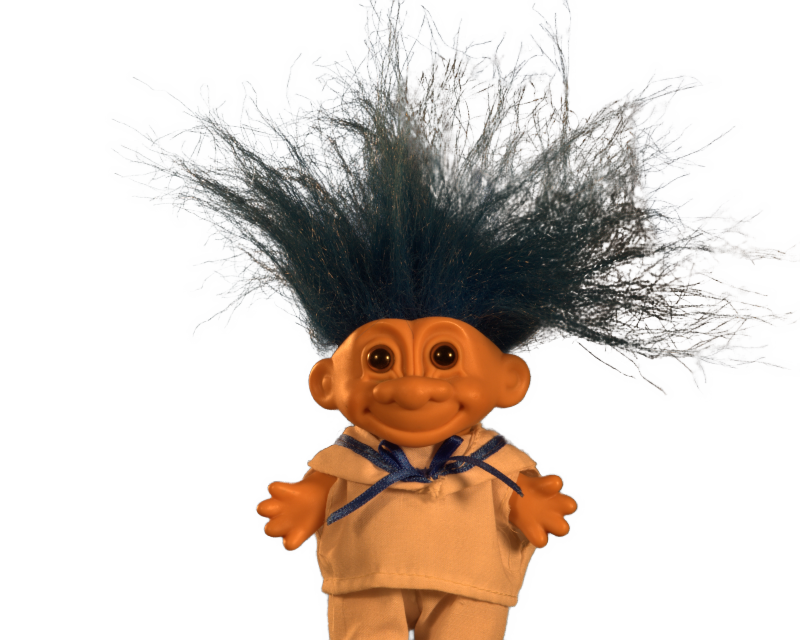

In [9]:
pic_input = "/home/jack155861/matting_pic/10_original.png"
tri_input = "/home/jack155861/matting_pic/10_trimap_01.png"
im = result_fn(model, pic_input, tri_input)
Image.fromarray(im)

/home/jack155861/.local/lib/python3.5/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


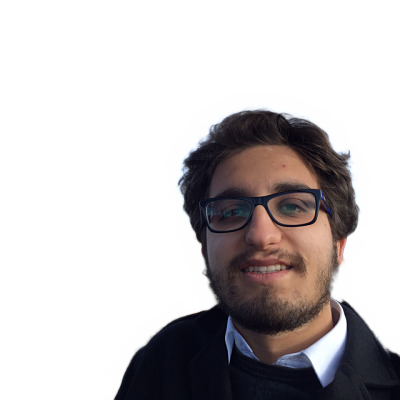

In [7]:
image_path = "image_doica-Copy1.jpg"
trimap_path = "output-Copy1.png"
im = result_fn(model, image_path, trimap_path)
Image.fromarray(im)